# Build some toy models and how to sample them

## Roadmap

- Step through training loop, line by line
- Run small training run!

In [15]:
# use autoreload
%load_ext autoreload
%autoreload 2

import yaml
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

# import lightning trainer
import lightning as L
from lightning.pytorch.loggers import WandbLogger

# imports
from jepa.modules import JEPA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Explore Model Loading

In [6]:
with open("configs/2_testing.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [7]:
model = JEPA(**config)

## Training Step

In [8]:
for batch in model.train_dataloader():
    x, mask, events_df = batch
    print(x.shape, mask.shape)

    context_mask, target_mask, inner_target_flag = model.sample_context(x, mask)
    print(context_mask.shape, target_mask.shape)

    break


torch.Size([1, 8, 2]) torch.Size([1, 8])
torch.Size([1, 8]) torch.Size([1, 8])


In [9]:
model.training_step(batch, 0)

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(0.6137, grad_fn=<MseLossBackward0>)

In [10]:
x, mask, *_ = batch
context_mask, target_mask, inner_target_flag = model.sample_context(x, mask)
x = x.permute(1, 0, 2)
target = model.embed_target(x, mask, target_mask)
context = model.encoder(x, context_mask, context_mask)
prediction = model.predictor(context, inner_target_flag)

loss = F.mse_loss(prediction, target)

In [11]:
x.shape, target_mask.shape

(torch.Size([8, 1, 2]), torch.Size([1, 8]))

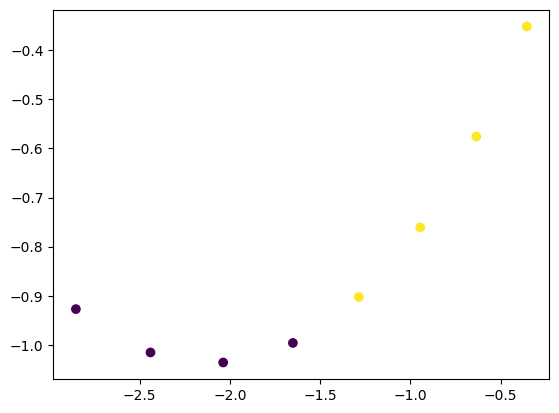

In [12]:
# Plot the x positions, along with whether they are in the context or target mask
plt.scatter(x[:, 0, 0], x[:, 0, 1], c=target_mask[0])
plt.show()

## Train Run

In [2]:
with open("configs/2_testing.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
model = JEPA(**config)

In [4]:
wandb_logger = WandbLogger(project="JEPA_toytrack_splittracks_1")
trainer = L.Trainer(
    max_epochs=100, 
    devices=1, 
    accelerator="gpu", 
    limit_train_batches = config["train_batches"], 
    limit_val_batches = config["val_batches"],
    logger = wandb_logger
)
trainer.fit(model=model)

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/jepa/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/jepa/lib/python ...
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_f

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                | Params
----------------------------------------------------
0 | encoder     | JEPAEncoder         | 5.6 K 
1 | ema_encoder | JEPAEncoder         | 5.6 K 
2 | predictor   | SplitTrackPredictor | 584   
----------------------------------------------------
6.2 K     Trainable params
5.6 K     Non-trainable params
11.8 K    Total params
0.047     Total estimated model params size (MB)


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s, v_num=jzz0]          

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/multiprocessing/resource_sharer.py", line 138, in _serve
    with self._listener.accept() as conn:
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/multiprocessing/connection.py", line 466, in accept
    answer_challenge(c, self._authkey)
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/multiprocessing/connection.py", line 752, in answer_challenge
    message = connection.recv_bytes(256)         # reject large message
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/multiprocessing/connection.py", line 383, in _recv
    raise EOFError
EOFErr

EOFError: 

In [7]:
trainer.fit(model=model)

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/jepa/lib/python ...
/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory ./JEPA_toytrack_splittracks_1/m0lg14u6/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                | Params
----------------------------------------------------
0 | encoder     | JEPAEncoder         | 5.6 K 
1 | ema_encoder | JEPAEncoder         | 5.6 K 
2 | predictor   | SplitTrackPredictor | 2.7 K 
----------------------------------------------------
8.3 K     Trainable params
5.6 K     Non-trainable params
13.9 K    Total params
0.

Epoch 41: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s, v_num=14u6]    

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Visualize Source-Target Encodings

In [9]:
model = model.to("cpu")

In [16]:
# Loop through a 10 batches, append the source, target encodings
source_encodings = []
target_encodings = []

batches = 0

with torch.no_grad():
    for batch in model.train_dataloader():
        results = model.shared_evaluation(batch, 0)
        source_encodings.append(results["context"].detach())
        target_encodings.append(results["target"].detach())
        batches += 1
        if batches > 10:
            break


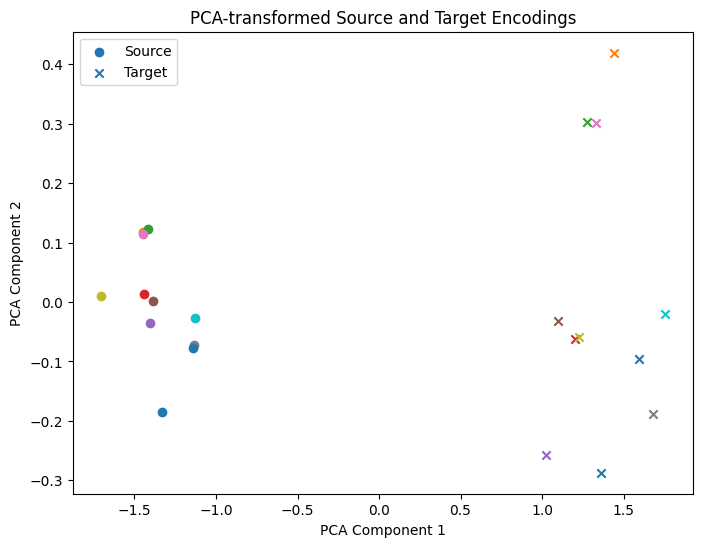

In [19]:
# Now PCA down the source and target encodings

# Sketch of changes:
# - Concatenate the source and target encodings into a single matrix
# - Perform PCA on the concatenated matrix to reduce dimensionality 
# - Extract the transformed source and target encodings from the PCA result
# - Visualize the PCA-transformed encodings in a scatter plot with matching colors for source and target encodings
# - Use 'o' for source encodings and 'x' for target encodings

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate source and target encodings
source_encodings_cat = np.concatenate([x.numpy() for x in source_encodings], axis=0)
target_encodings_cat = np.concatenate([x.numpy() for x in target_encodings], axis=0)
encodings_matrix = np.concatenate([source_encodings_cat, target_encodings_cat], axis=0)

# Perform PCA
pca = PCA(n_components=2)
pca_encodings = pca.fit_transform(encodings_matrix)

# Extract transformed source and target encodings
pca_source_encodings = pca_encodings[:len(source_encodings_cat)]
pca_target_encodings = pca_encodings[len(source_encodings_cat):]

# Visualize PCA-transformed encodings
plt.figure(figsize=(8, 6))
for i in range(len(pca_source_encodings)):
    plt.scatter(pca_source_encodings[i, 0], pca_source_encodings[i, 1], color=f'C{i}', marker='o', label='Source' if i == 0 else "")
    plt.scatter(pca_target_encodings[i, 0], pca_target_encodings[i, 1], color=f'C{i}', marker='x', label='Target' if i == 0 else "")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('PCA-transformed Source and Target Encodings')
plt.show()

In [21]:
# Loop through a 10 batches, append the source, target encodings
prediction_encodings = []
target_encodings = []

batches = 0

with torch.no_grad():
    for batch in model.train_dataloader():
        results = model.shared_evaluation(batch, 0)
        prediction_encodings.append(results["prediction"].detach())
        target_encodings.append(results["target"].detach())
        batches += 1
        if batches > 10:
            break


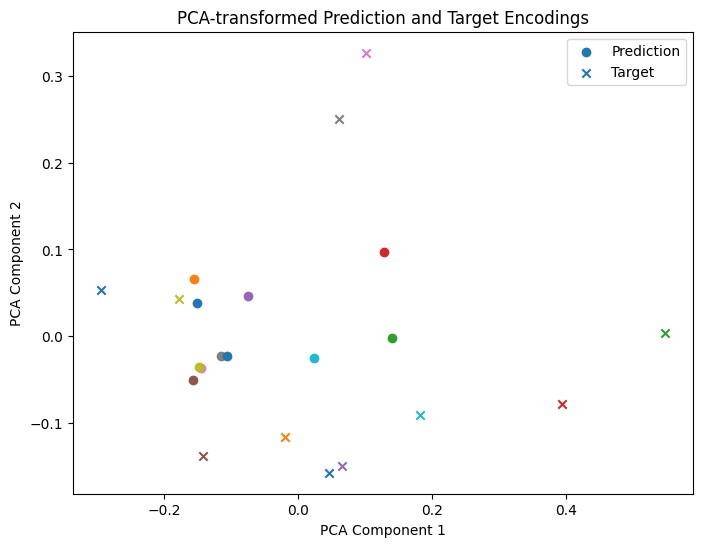

In [23]:
# Now PCA down the source and target encodings

# Sketch of changes:
# - Concatenate the source and target encodings into a single matrix
# - Perform PCA on the concatenated matrix to reduce dimensionality 
# - Extract the transformed source and target encodings from the PCA result
# - Visualize the PCA-transformed encodings in a scatter plot with matching colors for source and target encodings
# - Use 'o' for source encodings and 'x' for target encodings

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate source and target encodings
prediction_encodings_cat = np.concatenate([x.numpy() for x in prediction_encodings], axis=0)
target_encodings_cat = np.concatenate([x.numpy() for x in target_encodings], axis=0)
encodings_matrix = np.concatenate([prediction_encodings_cat, target_encodings_cat], axis=0)

# Perform PCA
pca = PCA(n_components=2)
pca_encodings = pca.fit_transform(encodings_matrix)

# Extract transformed source and target encodings
pca_prediction_encodings = pca_encodings[:len(prediction_encodings_cat)]
pca_target_encodings = pca_encodings[len(prediction_encodings_cat):]

# Visualize PCA-transformed encodings
plt.figure(figsize=(8, 6))
for i in range(len(pca_prediction_encodings)):
    plt.scatter(pca_prediction_encodings[i, 0], pca_prediction_encodings[i, 1], color=f'C{i}', marker='o', label='Prediction' if i == 0 else "")
    plt.scatter(pca_target_encodings[i, 0], pca_target_encodings[i, 1], color=f'C{i}', marker='x', label='Target' if i == 0 else "")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('PCA-transformed Prediction and Target Encodings')
plt.show()